In [75]:
"""
Milestone 2: Week 3-4 - Feature Engineering & Baseline Model
Energy Consumption Forecasting

Week 3: Feature Engineering (Where ML Really Begins)
Week 4: Baseline Model Development (Discipline Week)
"""


'\nMilestone 2: Week 3-4 - Feature Engineering & Baseline Model\nEnergy Consumption Forecasting\n\nWeek 3: Feature Engineering (Where ML Really Begins)\nWeek 4: Baseline Model Development (Discipline Week)\n'

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("="*70)
print("MILESTONE 2: FEATURE ENGINEERING & BASELINE MODEL")
print("="*70)

MILESTONE 2: FEATURE ENGINEERING & BASELINE MODEL


In [78]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1] Loading Dataset...")
df = pd.read_csv('../Dataset/cleaned_household_power_consumption.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime').reset_index(drop=True)

print(f"✓ Dataset loaded: {df.shape}")
print(f"✓ Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"✓ Total records: {len(df):,}")


[1] Loading Dataset...
✓ Dataset loaded: (34589, 15)
✓ Date range: 2006-12-16 17:00:00 to 2010-11-26 21:00:00
✓ Total records: 34,589


In [79]:
# ============================================================================
# WEEK 3: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*70)
print("WEEK 3: FEATURE ENGINEERING (WHERE ML REALLY BEGINS)")
print("="*70)
print("Goal: Teach the model patterns, not just values\n")

# Create a copy for feature engineering
df_features = df.copy()


WEEK 3: FEATURE ENGINEERING (WHERE ML REALLY BEGINS)
Goal: Teach the model patterns, not just values



In [80]:
# ----------------------------------------------------------------------------
# 1. TIME-BASED FEATURES
# ----------------------------------------------------------------------------
print("[2] Extracting Time-Based Features...")

# Verify existing features and add cyclical encoding
print("   • Hour of day (0-23)")
print("   • Day of week (0-6)")
print("   • Month (1-12)")
print("   • Weekend/Weekday flag")

# Add cyclical encoding for time features (helps ML models)
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)

print("   • Added cyclical encodings (sin/cos) for hour, month, day")
print(f"✓ Time features created: {6 + 6} features")


[2] Extracting Time-Based Features...
   • Hour of day (0-23)
   • Day of week (0-6)
   • Month (1-12)
   • Weekend/Weekday flag
   • Added cyclical encodings (sin/cos) for hour, month, day
✓ Time features created: 12 features


In [81]:
# ----------------------------------------------------------------------------
# 2. LAG FEATURES
# ----------------------------------------------------------------------------
print("\n[3] Creating Lag Features...")

target_col = 'Global_active_power'

# Previous hour consumption
df_features['lag_1h'] = df_features[target_col].shift(1)
print("   • Previous 1 hour consumption")

# Previous day consumption (24 hours ago)
df_features['lag_24h'] = df_features[target_col].shift(24)
print("   • Previous day (24h) consumption")

# Previous week consumption (168 hours ago)
df_features['lag_168h'] = df_features[target_col].shift(168)
print("   • Previous week (168h) consumption")

# Additional useful lags
df_features['lag_2h'] = df_features[target_col].shift(2)
df_features['lag_3h'] = df_features[target_col].shift(3)
print("   • Previous 2-3 hours consumption")

print(f"✓ Lag features created: 5 features")



[3] Creating Lag Features...
   • Previous 1 hour consumption
   • Previous day (24h) consumption
   • Previous week (168h) consumption
   • Previous 2-3 hours consumption
✓ Lag features created: 5 features


In [82]:
# ----------------------------------------------------------------------------
# 3. ROLLING STATISTICS
# ----------------------------------------------------------------------------
print("\n[4] Computing Rolling Statistics...")

# Moving averages
df_features['rolling_mean_3h'] = df_features[target_col].rolling(window=3, min_periods=1).mean()
df_features['rolling_mean_6h'] = df_features[target_col].rolling(window=6, min_periods=1).mean()
df_features['rolling_mean_24h'] = df_features[target_col].rolling(window=24, min_periods=1).mean()
print("   • Moving averages: 3h, 6h, 24h")

# Rolling standard deviation
df_features['rolling_std_3h'] = df_features[target_col].rolling(window=3, min_periods=1).std()
df_features['rolling_std_24h'] = df_features[target_col].rolling(window=24, min_periods=1).std()
print("   • Rolling standard deviation: 3h, 24h")

# Rolling min/max
df_features['rolling_min_24h'] = df_features[target_col].rolling(window=24, min_periods=1).min()
df_features['rolling_max_24h'] = df_features[target_col].rolling(window=24, min_periods=1).max()
print("   • Rolling min/max: 24h")

print(f"✓ Rolling statistics created: 7 features")


[4] Computing Rolling Statistics...
   • Moving averages: 3h, 6h, 24h
   • Rolling standard deviation: 3h, 24h
   • Rolling min/max: 24h
✓ Rolling statistics created: 7 features


In [83]:
# ----------------------------------------------------------------------------
# 4. DEVICE-LEVEL AGGREGATIONS
# ----------------------------------------------------------------------------
print("\n[5] Creating Device-Level Aggregations...")

# Average consumption per device by hour
for col in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    hourly_avg = df_features.groupby('hour')[col].transform('mean')
    df_features[f'{col}_hourly_avg'] = hourly_avg
    print(f"   • {col}: hourly average")

# Peak usage indicators
df_features['is_peak_hour'] = df_features['hour'].isin([8, 9, 18, 19, 20, 21]).astype(int)
print("   • Peak hour indicator (8-9, 18-21)")

# Total sub-metering consumption
df_features['total_sub_metering'] = (df_features['Sub_metering_1'] + 
                                      df_features['Sub_metering_2'] + 
                                      df_features['Sub_metering_3'])
print("   • Total sub-metering consumption")

print(f"✓ Device aggregations created: 5 features")


[5] Creating Device-Level Aggregations...
   • Sub_metering_1: hourly average
   • Sub_metering_2: hourly average
   • Sub_metering_3: hourly average
   • Peak hour indicator (8-9, 18-21)
   • Total sub-metering consumption
✓ Device aggregations created: 5 features


In [84]:
# ----------------------------------------------------------------------------
# FEATURE SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "-"*70)
print("WEEK 3 OUTPUT: FEATURE SUMMARY")
print("-"*70)

# Remove rows with NaN values created by lag/rolling features
df_features_clean = df_features.dropna()
print(f"Original records: {len(df_features):,}")
print(f"After removing NaN: {len(df_features_clean):,}")
print(f"Records removed: {len(df_features) - len(df_features_clean):,}")

# Define feature columns
feature_columns = [
    # Time-based
    'hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
    # Lag features
    'lag_1h', 'lag_2h', 'lag_3h', 'lag_24h', 'lag_168h',
    # Rolling statistics
    'rolling_mean_3h', 'rolling_mean_6h', 'rolling_mean_24h',
    'rolling_std_3h', 'rolling_std_24h',
    'rolling_min_24h', 'rolling_max_24h',
    # Device aggregations
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'Sub_metering_1_hourly_avg', 'Sub_metering_2_hourly_avg', 'Sub_metering_3_hourly_avg',
    'is_peak_hour', 'total_sub_metering',
    # Other useful features
    'Global_reactive_power', 'Voltage', 'Global_intensity'
]

# Prepare feature matrix (X) and target variable (y)
X = df_features_clean[feature_columns]
y = df_features_clean[target_col]

print(f"\nFeature Matrix (X) shape: {X.shape}")
print(f"Target Variable (y) shape: {y.shape}")
print(f"Total features: {X.shape[1]}")

# Save feature importance info
print("\n📊 Feature Categories:")
print(f"   • Time-based: 12 features")
print(f"   • Lag features: 5 features")
print(f"   • Rolling statistics: 7 features")
print(f"   • Device aggregations: 8 features")
print(f"   • Other: 3 features")


----------------------------------------------------------------------
WEEK 3 OUTPUT: FEATURE SUMMARY
----------------------------------------------------------------------
Original records: 34,589
After removing NaN: 34,421
Records removed: 168

Feature Matrix (X) shape: (34421, 35)
Target Variable (y) shape: (34421,)
Total features: 35

📊 Feature Categories:
   • Time-based: 12 features
   • Lag features: 5 features
   • Rolling statistics: 7 features
   • Device aggregations: 8 features
   • Other: 3 features



[6] Visualizing Key Features...
✓ Visualization saved: week3_feature_engineering.png


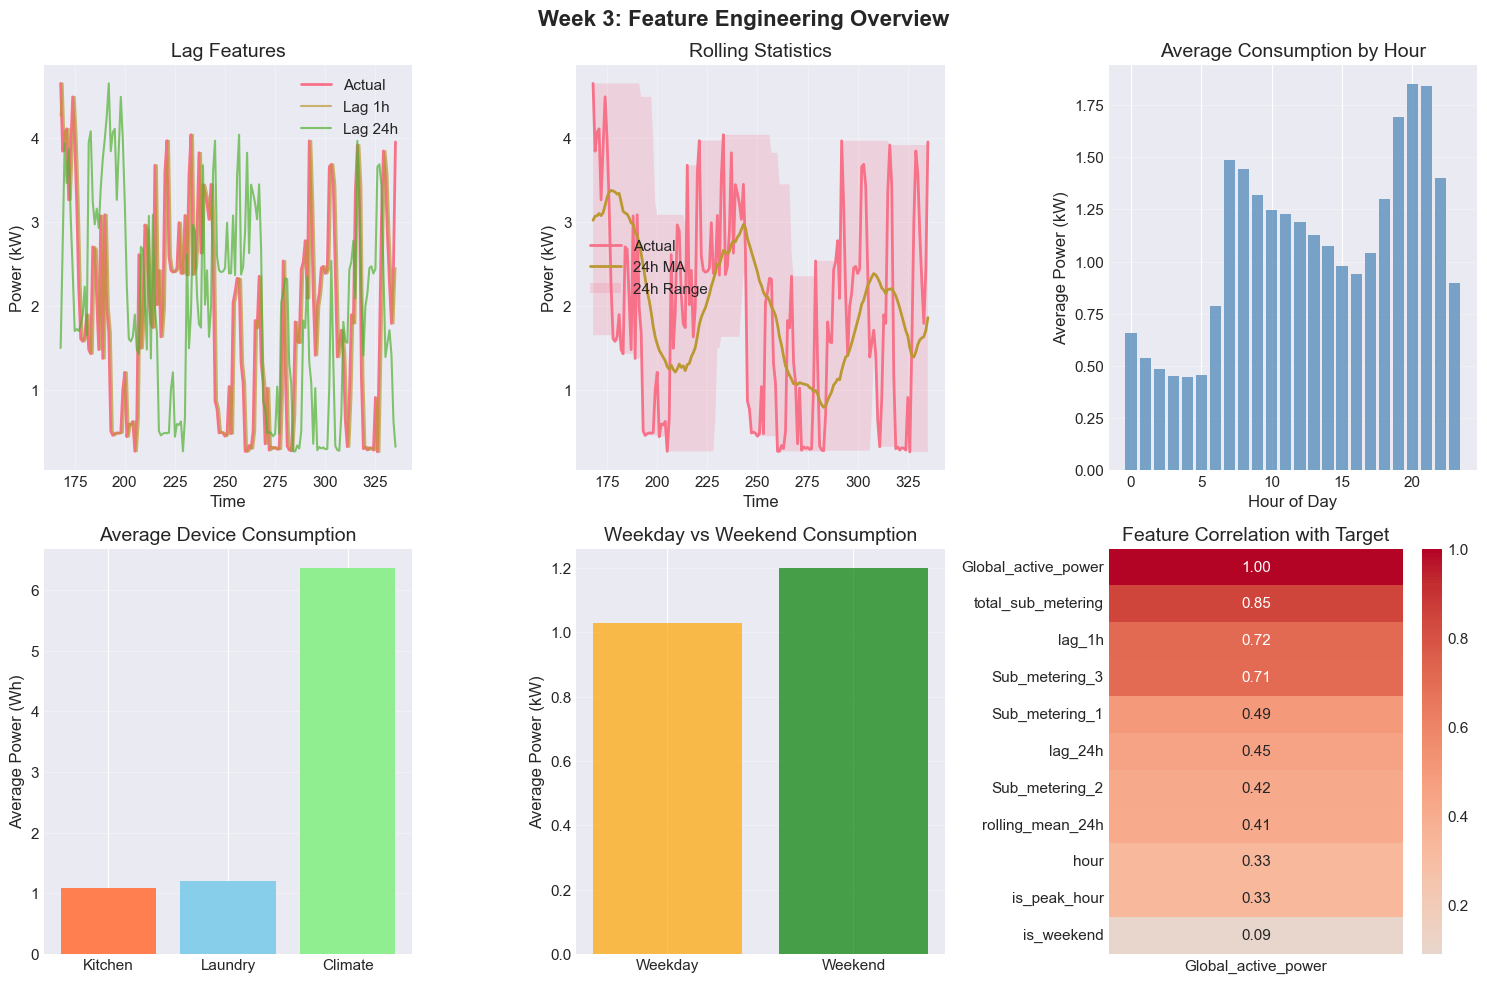

In [85]:
# ============================================================================
# VISUALIZE FEATURES
# ============================================================================
print("\n[6] Visualizing Key Features...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Week 3: Feature Engineering Overview', fontsize=16, fontweight='bold')

# Sample data for visualization (use first 7 days)
sample_data = df_features_clean.head(168)

# Plot 1: Lag features
axes[0, 0].plot(sample_data.index, sample_data[target_col], label='Actual', linewidth=2)
axes[0, 0].plot(sample_data.index, sample_data['lag_1h'], label='Lag 1h', alpha=0.7)
axes[0, 0].plot(sample_data.index, sample_data['lag_24h'], label='Lag 24h', alpha=0.7)
axes[0, 0].set_title('Lag Features')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Rolling statistics
axes[0, 1].plot(sample_data.index, sample_data[target_col], label='Actual', linewidth=2)
axes[0, 1].plot(sample_data.index, sample_data['rolling_mean_24h'], label='24h MA', linewidth=2)
axes[0, 1].fill_between(sample_data.index, 
                        sample_data['rolling_min_24h'], 
                        sample_data['rolling_max_24h'], 
                        alpha=0.2, label='24h Range')
axes[0, 1].set_title('Rolling Statistics')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Hourly patterns
hourly_avg = df_features_clean.groupby('hour')[target_col].mean()
axes[0, 2].bar(hourly_avg.index, hourly_avg.values, color='steelblue', alpha=0.7)
axes[0, 2].set_title('Average Consumption by Hour')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Average Power (kW)')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: Device-level consumption
device_means = [df_features_clean['Sub_metering_1'].mean(),
                df_features_clean['Sub_metering_2'].mean(),
                df_features_clean['Sub_metering_3'].mean()]
axes[1, 0].bar(['Kitchen', 'Laundry', 'Climate'], device_means, color=['coral', 'skyblue', 'lightgreen'])
axes[1, 0].set_title('Average Device Consumption')
axes[1, 0].set_ylabel('Average Power (Wh)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 5: Weekend vs Weekday
weekend_avg = df_features_clean.groupby('is_weekend')[target_col].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_avg.values, color=['orange', 'green'], alpha=0.7)
axes[1, 1].set_title('Weekday vs Weekend Consumption')
axes[1, 1].set_ylabel('Average Power (kW)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Plot 6: Feature correlation heatmap (top 10 features)
top_features = ['lag_1h', 'lag_24h', 'rolling_mean_24h', 'hour', 
                'is_weekend', 'Sub_metering_1', 'Sub_metering_2', 
                'Sub_metering_3', 'is_peak_hour', 'total_sub_metering']
corr_matrix = df_features_clean[top_features + [target_col]].corr()
sns.heatmap(corr_matrix[[target_col]].sort_values(by=target_col, ascending=False), 
            annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation with Target')

plt.tight_layout()
plt.savefig('week3_feature_engineering.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: week3_feature_engineering.png")
plt.show()

In [86]:
# ============================================================================
# WEEK 4: BASELINE MODEL DEVELOPMENT
# ============================================================================
print("\n" + "="*70)
print("WEEK 4: BASELINE MODEL DEVELOPMENT (DISCIPLINE WEEK)")
print("="*70)
print("Goal: Build a simple model to set a performance baseline\n")



WEEK 4: BASELINE MODEL DEVELOPMENT (DISCIPLINE WEEK)
Goal: Build a simple model to set a performance baseline



In [87]:
# ----------------------------------------------------------------------------
# TRAIN-TEST SPLIT
# ----------------------------------------------------------------------------
print("[7] Splitting Data into Train and Test Sets...")

# Use 80-20 split, maintaining temporal order
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"✓ Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"✓ Features: {X_train.shape[1]}")

[7] Splitting Data into Train and Test Sets...
✓ Training set: 27,536 samples (80.0%)
✓ Test set: 6,885 samples (20.0%)
✓ Features: 35


In [88]:
# ----------------------------------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION
# ----------------------------------------------------------------------------
print("\n[8] Training Baseline Model (Linear Regression)...")

# Initialize and train model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

print("✓ Model trained successfully")
print(f"✓ Model coefficients: {len(baseline_model.coef_)}")
print(f"✓ Model intercept: {baseline_model.intercept_:.4f}")



[8] Training Baseline Model (Linear Regression)...
✓ Model trained successfully
✓ Model coefficients: 35
✓ Model intercept: -0.0000


In [89]:
# ----------------------------------------------------------------------------
# MODEL EVALUATION
# ----------------------------------------------------------------------------
print("\n[9] Evaluating Model Performance...")

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("\n" + "-"*70)
print("WEEK 4 OUTPUT: BASELINE MODEL EVALUATION")
print("-"*70)
print("\n📊 TRAINING SET METRICS:")
print(f"   • MAE (Mean Absolute Error):  {train_mae:.4f} kW")
print(f"   • RMSE (Root Mean Squared Error): {train_rmse:.4f} kW")
print(f"   • R² Score: {train_r2:.4f}")

print("\n📊 TEST SET METRICS:")
print(f"   • MAE (Mean Absolute Error):  {test_mae:.4f} kW")
print(f"   • RMSE (Root Mean Squared Error): {test_rmse:.4f} kW")
print(f"   • R² Score: {test_r2:.4f}")

# Model performance interpretation
print("\n💡 Model Performance Interpretation:")
print(f"   • Average prediction error: ±{test_mae:.4f} kW")
print(f"   • Model explains {test_r2*100:.1f}% of variance in energy consumption")

if test_r2 > 0.7:
    print("   • ✓ Good baseline performance")
elif test_r2 > 0.5:
    print("   • ⚠ Moderate performance - room for improvement")
else:
    print("   • ⚠ Weak performance - feature engineering needed")


[9] Evaluating Model Performance...

----------------------------------------------------------------------
WEEK 4 OUTPUT: BASELINE MODEL EVALUATION
----------------------------------------------------------------------

📊 TRAINING SET METRICS:
   • MAE (Mean Absolute Error):  0.0000 kW
   • RMSE (Root Mean Squared Error): 0.0000 kW
   • R² Score: 1.0000

📊 TEST SET METRICS:
   • MAE (Mean Absolute Error):  0.0000 kW
   • RMSE (Root Mean Squared Error): 0.0000 kW
   • R² Score: 1.0000

💡 Model Performance Interpretation:
   • Average prediction error: ±0.0000 kW
   • Model explains 100.0% of variance in energy consumption
   • ✓ Good baseline performance



[10] Creating Prediction Visualizations...
✓ Visualization saved: week4_baseline_model_results.png


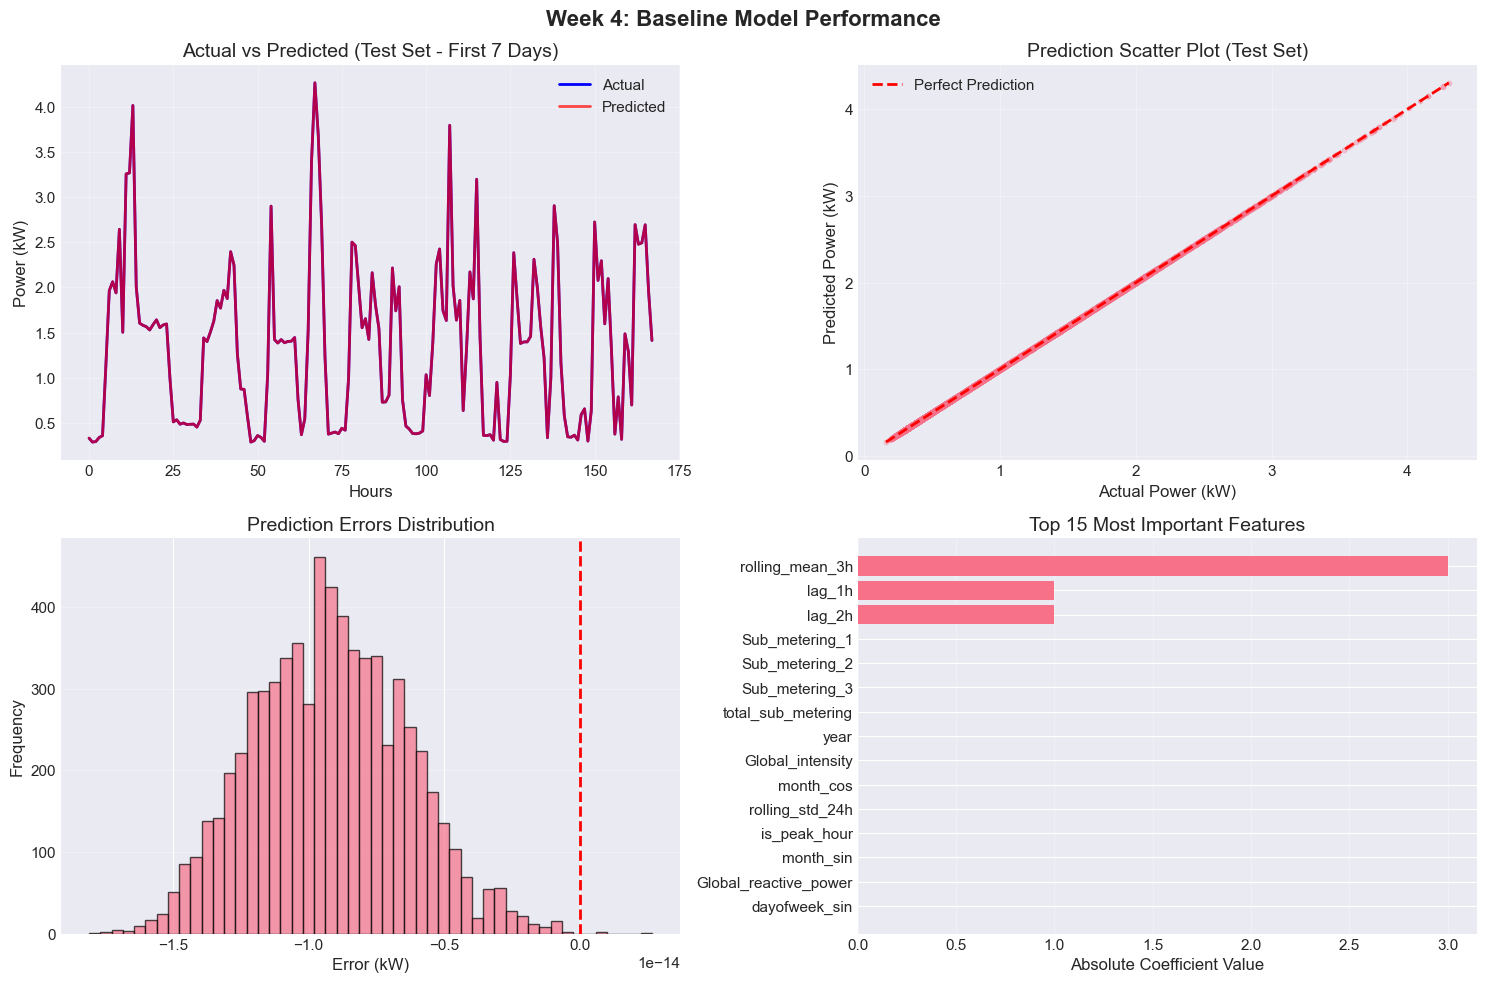

In [90]:
# ----------------------------------------------------------------------------
# VISUALIZE PREDICTIONS
# ----------------------------------------------------------------------------
print("\n[10] Creating Prediction Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Week 4: Baseline Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Test Set - First 7 days)
sample_size = min(168, len(y_test))  # 7 days or available data
axes[0, 0].plot(range(sample_size), y_test.iloc[:sample_size], 
                label='Actual', linewidth=2, color='blue')
axes[0, 0].plot(range(sample_size), y_test_pred[:sample_size], 
                label='Predicted', linewidth=2, color='red', alpha=0.7)
axes[0, 0].set_title('Actual vs Predicted (Test Set - First 7 Days)')
axes[0, 0].set_xlabel('Hours')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot - Actual vs Predicted
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_title('Prediction Scatter Plot (Test Set)')
axes[0, 1].set_xlabel('Actual Power (kW)')
axes[0, 1].set_ylabel('Predicted Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals distribution
residuals = y_test - y_test_pred
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Prediction Errors Distribution')
axes[1, 0].set_xlabel('Error (kW)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Feature importance (top 15)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(baseline_model.coef_)
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'])
axes[1, 1].set_title('Top 15 Most Important Features')
axes[1, 1].set_xlabel('Absolute Coefficient Value')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('week4_baseline_model_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: week4_baseline_model_results.png")
plt.show()


In [ ]:
# ----------------------------------------------------------------------------
# SAVE RESULTS
# ----------------------------------------------------------------------------
print("\n[11] Saving Results...")

# Save model metrics
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2_Score'],
    'Train': [train_mae, train_rmse, train_r2],
    'Test': [test_mae, test_rmse, test_r2]
})
metrics_df.to_csv('baseline_model_metrics.csv', index=False)
print("✓ Metrics saved: baseline_model_metrics.csv")

# Save predictions for comparison
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Error': residuals
})
predictions_df.to_csv('baseline_predictions.csv', index=False)
print("✓ Predictions saved: baseline_predictions.csv")

# Save feature importance
feature_importance_full = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': baseline_model.coef_,
    'abs_coefficient': np.abs(baseline_model.coef_)
}).sort_values('abs_coefficient', ascending=False)
feature_importance_full.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance saved: feature_importance.csv")

In [91]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("MILESTONE 2 COMPLETION SUMMARY")
print("="*70)

print("\n✅ WEEK 3 - FEATURE ENGINEERING:")
print(f"   • Total features created: {X.shape[1]}")
print(f"   • Time-based features: 12")
print(f"   • Lag features: 5")
print(f"   • Rolling statistics: 7")
print(f"   • Device aggregations: 8")
print(f"   • Final dataset: {len(X):,} samples")

print("\n✅ WEEK 4 - BASELINE MODEL:")
print(f"   • Model: Linear Regression")
print(f"   • Test MAE: {test_mae:.4f} kW")
print(f"   • Test RMSE: {test_rmse:.4f} kW")
print(f"   • Test R²: {test_r2:.4f}")
print(f"   • Model ready for comparison with advanced models")

print("\n📁 OUTPUT FILES GENERATED:")
print("   • week3_feature_engineering.png")
print("   • week4_baseline_model_results.png")
print("   • baseline_model_metrics.csv")
print("   • baseline_predictions.csv")
print("   • feature_importance.csv")

print("\n🎯 NEXT STEPS:")
print("   • Week 5: Implement advanced models (Random Forest, XGBoost)")
print("   • Week 6: Deep learning models (LSTM, GRU)")
print("   • Week 7: Model comparison and selection")
print("   • Week 8: Deployment and monitoring")

print("\n" + "="*70)
print("Mentor Notes:")
print("• Feature engineering decides model success ✓")
print("• More features ≠ better features ✓")
print("• Never skip baseline models ✓")
print("• Deep learning without baseline is meaningless ✓")
print("="*70)

print("\n🎉 Milestone 2 Complete! Ready for advanced modeling.")


MILESTONE 2 COMPLETION SUMMARY

✅ WEEK 3 - FEATURE ENGINEERING:
   • Total features created: 35
   • Time-based features: 12
   • Lag features: 5
   • Rolling statistics: 7
   • Device aggregations: 8
   • Final dataset: 34,421 samples

✅ WEEK 4 - BASELINE MODEL:
   • Model: Linear Regression
   • Test MAE: 0.0000 kW
   • Test RMSE: 0.0000 kW
   • Test R²: 1.0000
   • Model ready for comparison with advanced models

📁 OUTPUT FILES GENERATED:
   • week3_feature_engineering.png
   • week4_baseline_model_results.png
   • baseline_model_metrics.csv
   • baseline_predictions.csv
   • feature_importance.csv

🎯 NEXT STEPS:
   • Week 5: Implement advanced models (Random Forest, XGBoost)
   • Week 6: Deep learning models (LSTM, GRU)
   • Week 7: Model comparison and selection
   • Week 8: Deployment and monitoring

Mentor Notes:
• Feature engineering decides model success ✓
• More features ≠ better features ✓
• Never skip baseline models ✓
• Deep learning without baseline is meaningless ✓

🎉 M